In [7]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
# Für Pynq
from pynq import Overlay
from pynq import allocate
# ol = Overlay("Matlab_Filter_v2_18_4.bit")  # max output2^18, dma 2^26 (max), FilterOrder = 4, elliptic, v.2.2
# ol = Overlay("Matlab_Filter_v2_18_4_v2.bit")  # max output2^18, dma 2^26 (max),Fc 1 kHz, FilterOrder = 4, elliptic, v.2.3
ol = Overlay("Matlab_Filter_v2_18_4_v3.bit")  # max output2^18, dma 2^26 (max),Fc 1 kHz, FilterOrder = 4,butter, v.2.3
# Check IP names
ol.ip_dict.keys()

dict_keys(['axi_dma_0', 'BiquadFilter_HP_Butt_0', 'processing_system7_0'])

In [8]:
# Zuweisung für dma
dma = ol.axi_dma_0
dma_send = ol.axi_dma_0.sendchannel
dma_recv = ol.axi_dma_0.recvchannel
# check status
print("Error: ", dma_recv.error, "Idle: ", dma_recv.idle, "Running: ", dma_recv.running)
print("Error: ", dma_send.error, "Idle: ", dma_send.idle, "Running: ", dma_send.running)

Error:  False Idle:  False Running:  True
Error:  False Idle:  False Running:  True


In [13]:
# Funktionen
def FormatChange(x):
    x = x * (2**15)                            # Skalieren auf Q16.16 Bereich (optional leicht unter max)
    x = x.astype(np.int32)                     # Als 32-Bit Integer interpretieren
    input_data = x.view(np.uint32)             # Für DMA als unsigned darstellen
    return input_data

def Normierung (x):
    m = np.max(np.abs(x))                      # Maxwert für Normalisierung
    x_n = x / m 
    return x_n

def Transmission(input_data,ip_buffer):
    # Festlegen der Größen
    buffer_size = int(ip_buffer)
    print("Buffer Size: ", buffer_size)
    input_data = FormatChange(Normierung(input_data))
    data_size = int(len(input_data))
    print('Data Size: ', data_size)
    
    # Padding
    pad = np.zeros(ip_buffer)
    pad_frame = FormatChange(pad)
    print('Frame Length: ', len(pad_frame),' / ', 'Frame Type: ', type(pad_frame))
    
    # Leere Buffer
    input_buffer = allocate(shape=(buffer_size,), dtype=np.uint32)
    output_buffer = allocate(shape=(buffer_size,), dtype=np.uint32)
    
    # Padding Inputbuffer
    input_buffer[:] = pad_frame
    
    # Laden der Daten in Inputbuffer
    input_buffer[: data_size] = input_data
    print('Input Buffer: ', input_buffer[: data_size])
    
    # Senden un Empfangen der Daten
    dma.sendchannel.transfer(input_buffer)
    dma.recvchannel.transfer(output_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.wait()
    
    # check status
    #print("Recv Status: ","Error: ", dma_recv.error, "Idle: ", dma_recv.idle, "Running: ", dma_recv.running)
    #print("Send Status: ","Error: ", dma_send.error, "Idle: ", dma_send.idle, "Running: ", dma_send.running)
    
    print('Output Buffer: ', output_buffer[: data_size])
    
    # Check for Error
    if dma_recv.error == False and dma_send.error == False:
        print('>>>> Transmission successful <<<<')
    elif dma_recv.error == True or dma_send.error == True:
        print('!!!>> Error in Transmission <<!!!')
    
    # Umrechnen der Empfangenen Daten
    output_data = np.array(output_buffer[: data_size]).view(np.int32)  # zurück zu signed int32
    # output_data = np.array(output_buffer).view(np.int32)  Test des Kompletten Frame
    y = output_data / (2**15)
    
    
    # Buffer leeren
    del input_buffer, output_buffer
    print('Buffer Clear')
    print('>-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-<')
    
    return y
    
def Split2Packets(data,packet_size):
    packets = []
    for i in range(0, len(data), packet_size):
        packet = data[i:i+packet_size]
        packets.append(packet)
    return packets  



4410 4410 <class 'numpy.ndarray'>


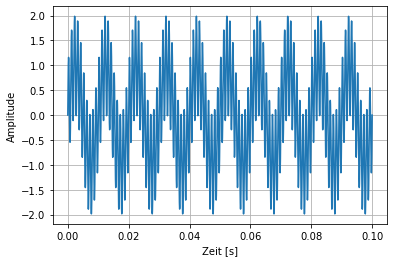

In [10]:
# Generierung Test Signals
sampleRate = 44100
T = 0.1
t = np.linspace(0,T,int(sampleRate*T))
x = np.sin(1000 * 2 * np.pi * t) + np.sin(100 * 2 * np.pi * t)

print(len(t), len(x), type(x))
plt.plot(t,x)
plt.xlabel("Zeit [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


In [14]:
ip_buffer = 2**18
Data_In = x
Data_Out = []

# Zerteilung und Übertragung in Packeten
Packets = Split2Packets(Data_In, ip_buffer)

for packet in Packets:
    result = Transmission(packet, ip_buffer)
    Data_Out.extend(result)

Buffer Size:  262144
Data Size:  4410
Frame Length:  262144  /  Frame Type:  <class 'numpy.ndarray'>
Input Buffer:  [         0       2576       5104 ... 4294962192 4294964720          0]
Output Buffer:  [   0 2138 3438 ... 3287 1664    9]
>>>> Transmission successful <<<<
Buffer Clear
>-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-<


4410


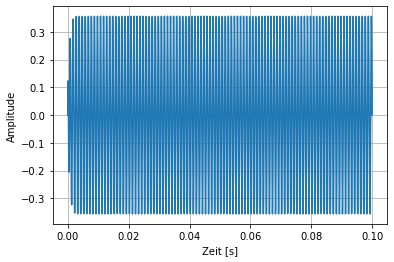

In [15]:
# Empfangene Daten plotten
y = Data_Out
print(len(y))
plt.plot(t,y)
plt.xlabel("Zeit [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()